## Node classification

Followed from https://arxiv.org/pdf/1603.08861
Graph embeddings are a way to represent the nodes, edges, or entire graphs in a continuous vector space. This transformation makes it easier to apply machine learning algorithms to graph-structured data


In [37]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
import torch
from torch_geometric.nn import GCNConv, GATConv
import torch.nn.functional as F
from sklearn.manifold import TSNE
import seaborn as sns
import torch.nn.functional as F



In [ ]:
dataset = Planetoid(root='data/Planetoid', name='PubMed', transform=NormalizeFeatures())



In [11]:
dir(dataset)

['__add__',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_data',
 '_data_list',
 '_download',
 '_indices',
 '_infer_num_classes',
 '_is_protocol',
 '_process',
 'collate',
 'copy',
 'cpu',
 'cuda',
 'data',
 'download',
 'force_reload',
 'geom_gcn_url',
 'get',
 'get_summary',
 'has_download',
 'has_process',
 'index_select',
 'indices',
 'len',
 'load',
 'log',
 'name',
 'num_classes',
 'num_edge_features',
 'num_features',
 'num_node_features',
 'pre_filter',
 'pre_transform',
 'print_summary',
 'process',
 'proces

In [30]:
print(f'Dataset: {dataset}:')
print(f'# graphs: {len(dataset)}')
print(f'# features: {dataset.num_features}')
print(f'# classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.
print(data)


Dataset: PubMed():
# graphs: 1
# features: 500
# classes: 3
Data(x=[19717, 500], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])


In [31]:
from collections import Counter
Counter(data.y.cpu().numpy())

Counter({2: 7875, 1: 7739, 0: 4103})

In [46]:
class GNN_PubMed(torch.nn.Module):
    def __init__(self, num_hidden, num_features,num_class) -> None:
        super().__init__()
        self.conv1 = GCNConv(num_features,num_hidden)
        self.conv2 = GCNConv(num_hidden,num_class)
        
    def forward(self,x,edges_index):
        x = self.conv1(x,edges_index)
        x = x.relu()
        x = F.dropout(x,p=0.2,training=self.training)
        x = self.conv2(x,edges_index)
        return x


In [47]:
##Instance of the model
model = GNN_PubMed(num_hidden=16,num_features=dataset.num_features ,num_class=dataset.num_classes )
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [44]:
data.train_mask

tensor([ True,  True,  True,  ..., False, False, False])

In [ ]:
#%% Model Training with Early Stopping
model.train()
epochs = 1000
patience = 100  # Early stopping patience
best_loss = float('inf')
best_epoch = 0

train_losses = []

for epoch in range(epochs):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())
    print(f'Epoch: {epoch+1}, Loss: {loss.item()}')

    # Early stopping check
    if loss.item() < best_loss:
        best_loss = loss.item()
        best_epoch = epoch
    elif epoch - best_epoch > patience:
        print(f'Early stopping at epoch {epoch+1}')
        break
    


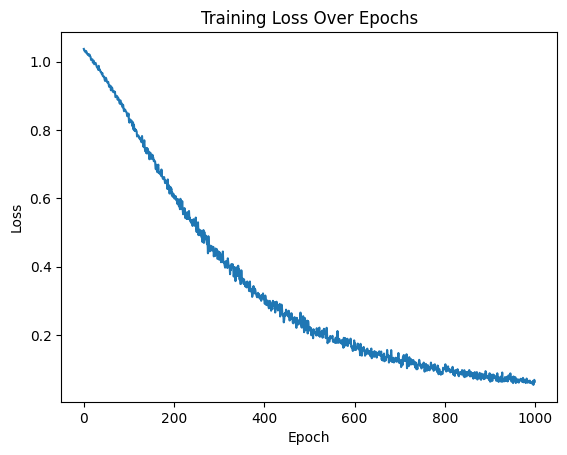

In [57]:

import matplotlib.pyplot as plt
# Train Loss Plot
sns.lineplot(x=list(range(len(train_losses))), y=train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()


Test Accuracy: 0.7680


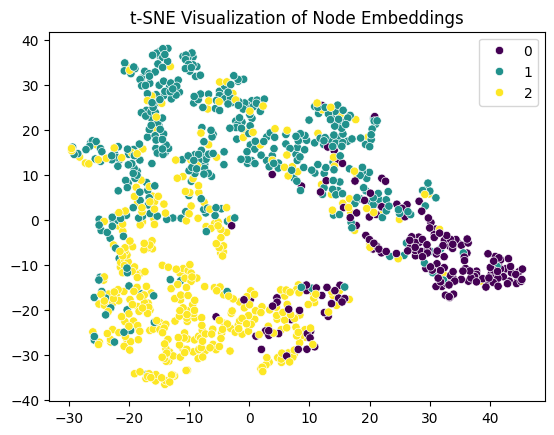

In [58]:

# Evaluation
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    acc = int(correct) / int(data.test_mask.sum())
print(f'Test Accuracy: {acc:.4f}')

#%% Visualization of Results
z = TSNE(n_components=2).fit_transform(out[data.test_mask].detach().cpu().numpy())
sns.scatterplot(x=z[:, 0], y=z[:, 1], hue=data.y[data.test_mask].cpu().numpy(), palette='viridis')
plt.title('t-SNE Visualization of Node Embeddings')
plt.show()